In [1]:
from TCSPC import *

In [2]:
plt.rcParams['figure.constrained_layout.use'] = True

In [3]:
EGFP = Simulation([0.497,0.503],[2.43,3.07])

In [4]:
# tdata = np.loadtxt('EGFPt.csv')
# ydata = np.loadtxt('EGFPy2.csv')

In [5]:
def trim_rescale_data(tdata,ydata,r = 0.1,end =int(0.6*380),rescale = True):
    '''Trim and rescale data (if rescale ==True)
       tdata    EGFP.t
       ydata    EGFP.y2 
       r        select points with y>r*max(y)
       rescale  True to rescale, False won't rescale'''
     #select points >r* max ydata only
    ydata = ydata[ydata>r*np.max(yda
                                 
                                 ta)]
    #trim away IRF
    ydata = ydata[np.argmax(ydata):]
    #set tdata to same length, start from t = 0
    tdata = tdata[:len(ydata)]
    if rescale == True:
        yerr = ydata/ydata[0]*np.sqrt(1/ydata+1/ydata[0]) #error after scaling
        ydata = ydata/ydata[0] # scale y data such that the beginning is 1 
    else:
        yerr = np.sqrt(ydata)
    weights = 1/yerr #weighted by 1/yerr, yerr is error after scaling ydata
    return tdata,ydata,weights

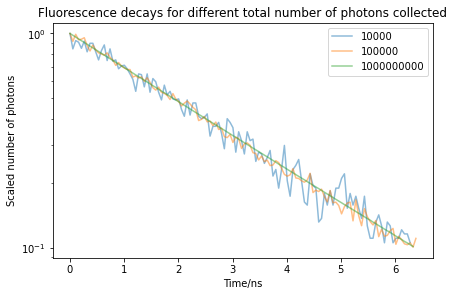

In [6]:
for n_photon in [int(1e4),int(1e5),int(1e9)]:
    EGFP.n_photon = n_photon
    EGFP.multi_exp_data()
    tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2,rescale = True)
    plt.plot(tdata,ydata,alpha = 0.5,label = str(n_photon))
plt.legend()
plt.title('Fluorescence decays for different total number of photons collected' )
plt.xlabel('Time/ns')
plt.ylabel('Scaled number of photons')
plt.yscale('log')

In [7]:
def exp(t, A, tau):
    return A * np.exp(-t/tau)

In [8]:
np.argmax(ydata)

0

In [9]:
tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2)
len(tdata)

121

In [31]:
def poisson_deviance_residual(observed, expected):
    '''Return Poisson deviance residual array for given observed data and expected (model) '''
    residual=  np.sign(observed-expected)*np.sqrt(abs(2 *  (observed* np.log(observed/ expected) - (observed- expected)))) #residual array
    return residual

def residual(p, t, data):
    '''Return residual array for lmfit.minimizer to minimize in the sum of squares sense
       Inputs:
       p         lmfit.Parameters() object
       t         time array (independent variable)
       data      data array to be fitted'''
    v = p.valuesdict() #obtain dictionary of parameter values
    expected = 0
    if 'c' in v:
        expected = v['c'] #constant background
    M = 1
    while f'A{M}' in v:
        expected += exp(t, v[f'A{M}'], v[f'tau{M}']) #add exponential component
        M += 1
    return poisson_deviance_residual(data, expected) #lmfit.minimizer minimize the residual array in the sum of squared sense

def initial_params(M,A_guess,tau_guess,c_guess = 0,rescale = True,bg_removed = False):
    '''Create and return initial parameters of fit (lmfit.Parmaeters() object)
       Input:
       M          number of lifetime components
       A_guess    np.array of A1,...AM amplitudes guess
       tau_guess  np.array of tau1,...tauM lifetimes guess
       c_guess    constant background offset guess
       rescale    True if the ydata is rescaled
       bg_removed True if bg is removed
       '''
    p = lmfit.Parameters()
    if bg_removed == False:
        p.add_many(('c', c_guess, True, 0)) #constant background
    for i in range(1,M+1): #for each component
        p.add_many((f'A{i}', A_guess[i-1], True,0)) #amplitude
    for i in range(1,M+1):
        p.add_many((f'tau{i}', tau_guess[i-1], True, 0)) #lifetime
    if rescale == True:
        p[f'A{M}'].set(expr = f'1 {"".join([f"- A{i}" for i in range(1,M)])}') #fix the amplitude of last component
    return p


In [32]:
def initial_params(M,A_guess,tau_guess,c_guess = 0,rescale = True,bg_removed = False):
    p = lmfit.Parameters()
    if bg_removed == False:
        p.add_many(('c', c_guess, True, 0)) #constant background
    for i in range(1,M+1): #for each component
        p.add_many((f'A{i}', A_guess[i-1], True,0)) #amplitude
    for i in range(1,M+1):
        p.add_many((f'tau{i}', tau_guess[i-1], True, 0)) #lifetime
    if rescale == True:
        p[f'A{M}'].set(expr = f'1 {"".join([f"- A{i}" for i in range(1,M)])}') #fix the amplitude of last component
    return p



In [33]:
import numdifftools as nd

In [34]:
def chi2(params):
    '''Return chi2 from given parameters (np.array)'''
    M = int((len(params)-1)/2)
    p = initial_params(M,params[1:M+1],params[M+1:],c_guess=params[0],rescale = False)
    return np.dot(residual(p, tdata, ydata),residual(p, tdata, ydata))

### bi-exp decay fit to EGFP (with rescaled data)

In [35]:
EGFP.n_photon = int(1e5)
EGFP.multi_exp_data()
tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2-EGFP.bg*EGFP.run_time/380)
p1 = initial_params(2,EGFP.amp,EGFP.tau)
p1['c'].set(value = 0, vary = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method='powell')

print(lmfit.fit_report(mi1))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 181
    # data points      = 121
    # variables        = 3
    chi-square         = 0.07917143
    reduced chi-square = 6.7094e-04
    Akaike info crit   = -881.163563
    Bayesian info crit = -872.776191
[[Variables]]
    c:     0 (fixed)
    A1:    0.66696545 +/- 0.59053458 (88.54%) (init = 0.497)
    A2:    0.33303455 +/- 0.59053458 (177.32%) == '1 - A1'
    tau1:  2.20091015 +/- 0.54011455 (24.54%) (init = 2.43)
    tau2:  3.71638718 +/- 1.73257701 (46.62%) (init = 3.07)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, tau2)   = +0.9961
    C(A1, tau1)   = +0.9944
    C(tau1, tau2) = +0.9816


### No rescale (with removed background)

In [36]:
#generate data for a particular total collected photon number
EGFP.n_photon = int(1e5)
EGFP.multi_exp_data()

(array([ 0.        ,  0.05277045,  0.1055409 ,  0.15831135,  0.21108179,
         0.26385224,  0.31662269,  0.36939314,  0.42216359,  0.47493404,
         0.52770449,  0.58047493,  0.63324538,  0.68601583,  0.73878628,
         0.79155673,  0.84432718,  0.89709763,  0.94986807,  1.00263852,
         1.05540897,  1.10817942,  1.16094987,  1.21372032,  1.26649077,
         1.31926121,  1.37203166,  1.42480211,  1.47757256,  1.53034301,
         1.58311346,  1.63588391,  1.68865435,  1.7414248 ,  1.79419525,
         1.8469657 ,  1.89973615,  1.9525066 ,  2.00527704,  2.05804749,
         2.11081794,  2.16358839,  2.21635884,  2.26912929,  2.32189974,
         2.37467018,  2.42744063,  2.48021108,  2.53298153,  2.58575198,
         2.63852243,  2.69129288,  2.74406332,  2.79683377,  2.84960422,
         2.90237467,  2.95514512,  3.00791557,  3.06068602,  3.11345646,
         3.16622691,  3.21899736,  3.27176781,  3.32453826,  3.37730871,
         3.43007916,  3.4828496 ,  3.53562005,  3.5

In [37]:
y_no_bg = EGFP.y2-EGFP.bg*EGFP.run_time/EGFP.n_bins
y_with_bg = EGFP.y2
tdata,ydata,weights = trim_rescale_data(EGFP.t,y_no_bg,rescale = False) #bg removed
p1 = initial_params(2,np.max(EGFP.y2)*EGFP.amp,EGFP.tau,rescale = False)
p1['c'].set(value = 0, vary = False)
mi2 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')

print(lmfit.fit_report(mi2))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 161
    # data points      = 120
    # variables        = 4
    chi-square         = 103.850618
    reduced chi-square = 0.89526395
    Akaike info crit   = -9.34458870
    Bayesian info crit = 1.80537827
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:     0 (fixed)
    A1:    904.365574 (init = 938.833)
    A2:    950.661599 (init = 950.167)
    tau1:  2.45777660 (init = 2.43)
    tau2:  3.08490261 (init = 3.07)


In [38]:
tdata,ydata,weights = trim_rescale_data(EGFP.t,y_with_bg,rescale = False) #bg removed
p1['c'].set(value = 0, vary = True)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')
print(lmfit.fit_report(mi1))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 156
    # data points      = 121
    # variables        = 5
    chi-square         = 104.818474
    reduced chi-square = 0.90360754
    Akaike info crit   = -7.37082145
    Bayesian info crit = 6.60813127
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:     1.04045497 (init = 0)
    A1:    903.240386 (init = 938.833)
    A2:    951.581050 (init = 950.167)
    tau1:  2.46597371 (init = 2.43)
    tau2:  3.07557156 (init = 3.07)


### mono-exp decay fit to EGFP

In [39]:
p1

name,value,initial value,min,max,vary
c,0.00000000,0,0.00000000,inf,True
A1,938.833000,938.833,0.00000000,inf,True
A2,950.167000,950.167,0.00000000,inf,True
tau1,2.43000000,2.43,0.00000000,inf,True
tau2,3.07000000,3.07,0.00000000,inf,True


In [40]:
p1 = initial_params(1,[np.max(ydata)],EGFP.tau,rescale = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')
print(lmfit.fit_report(mi1))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 337
    # data points      = 121
    # variables        = 3
    chi-square         = 104.605225
    reduced chi-square = 0.88648496
    Akaike info crit   = -11.6172419
    Bayesian info crit = -3.22987022
[[Variables]]
    c:     4.52416328 +/- 10.4366067 (230.69%) (init = 0)
    A1:    1847.77330 +/- 10.0148658 (0.54%) (init = 1889)
    tau1:  2.76187566 +/- 0.04908154 (1.78%) (init = 2.43)
[[Correlations]] (unreported correlations are < 0.100)
    C(c, tau1)  = -0.9526
    C(c, A1)    = -0.3472
    C(A1, tau1) = +0.1082


In [41]:
np.sum(residual(mi1.params,tdata,ydata))

-0.798062499002278

## Triple-exp Fit

In [42]:

p1 = initial_params(3,[np.max(EGFP.y2*0.49),np.max(EGFP.y2)*0.51,100],EGFP.tau+[10],rescale = False)
mi3 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')

print(lmfit.fit_report(mi3))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 818
    # data points      = 121
    # variables        = 7
    chi-square         = 104.745931
    reduced chi-square = 0.91882395
    Akaike info crit   = -3.45459298
    Bayesian info crit = 16.1159408
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:     0.60304220 (init = 0)
    A1:    774.529868 (init = 925.61)
    A2:    1015.87661 (init = 963.39)
    A3:    64.1391430 (init = 100)
    tau1:  2.54588659 (init = 2.43)
    tau2:  2.85780503 (init = 3.07)
    tau3:  4.52641636 (init = 10)


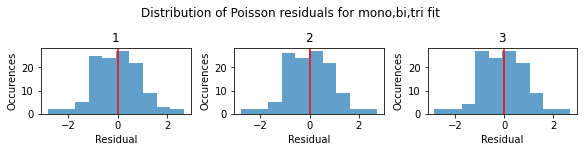

In [43]:
fig,ax = plt.subplots(ncols=3,figsize = (8,2))
fig.suptitle('Distribution of Poisson residuals for mono,bi,tri fit ')
for i in range(3):
    mi = [mi1,mi2,mi3][i]
    resid = residual(mi.params,tdata,ydata)
    ax[i].hist(resid,alpha = 0.7)
    ax[i].axvline(np.mean(residual(mi.params,tdata,ydata)),c='r',label = 'mean')
    ax[i].set_title(range(1,4)[i])
    ax[i].set_xlabel('Residual')
    ax[i].set_ylabel('Occurences')

## Get 100 simulation at each point (bi-exp decay)


In [110]:
def MLEfit(N,tdata,ydata,method ='powell',end=100,rescale=False):

    tdata, ydata, weights = trim_rescale_data(tdata,ydata, end=end, rescale=rescale)
    p1 = initial_params(N, [np.max(ydata * 0.49), np.max(ydata) * 0.51], EGFP.tau, rescale=rescale)
    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k:[v.value] for k,v in mi1.params.items()} #turn params values into dict
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1,N+1)]) #sum all An
    for i in range(1,N+1):
      par_dict[f'A{i}'][0]=par_dict[f'A{i}'][0]/A_sum

    return pd.DataFrame.from_dict(par_dict)
MLEfit(2,EGFP.t,EGFP.sim_data[i])

,c,A1,A2,tau1,tau2
0,9807.569717,0.489993,0.510007,2.425186,3.066811


In [45]:
def MLEfit(N,tdata,ydata,method ='powell',end=100,rescale=False):

    tdata, ydata, weights = trim_rescale_data(tdata,ydata, end=end, rescale=rescale)
    p1 = initial_params(N, [np.max(ydata * 0.49), np.max(ydata) * 0.51], EGFP.tau, rescale=rescale)
    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k:[v.value] for k,v in mi1.params.items()} #turn params values into dict
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1,N+1)]) #sum all An
    for i in range(1,N+1):
      par_dict[f'A{i}'][0]=par_dict[f'A{i}'][0]/A_sum

    return pd.DataFrame.from_dict(par_dict)

def val_df():
  '''Create dataframe of fitted parameters'''
  df_list = []
  for j in range(100):
    df_list.append( MLEfit(N,EGFP.t,EGFP.sim_data[j]))
    df= pd.concat(df_list).reset_index()
  return df.drop(['index'],axis =1)

N=2 #components
EGFP.y_list = np.zeros((20,100,380))
n_photon_arr = np.logspace(4,9,20)
df_list = []
for i in range(len(n_photon_arr)):
  EGFP.n_photon = n_photon_arr[i]
  EGFP.repeat_sim(100)
  EGFP.y_list[i] = EGFP.sim_data
  df =val_df()
  df_list.append(df)


In [46]:
df = val_df()

In [47]:

n_val_df =pd.concat(df_list,keys = range(20))

<ipython-input-48-5a7bf21794ab>:21: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(top=0.85)


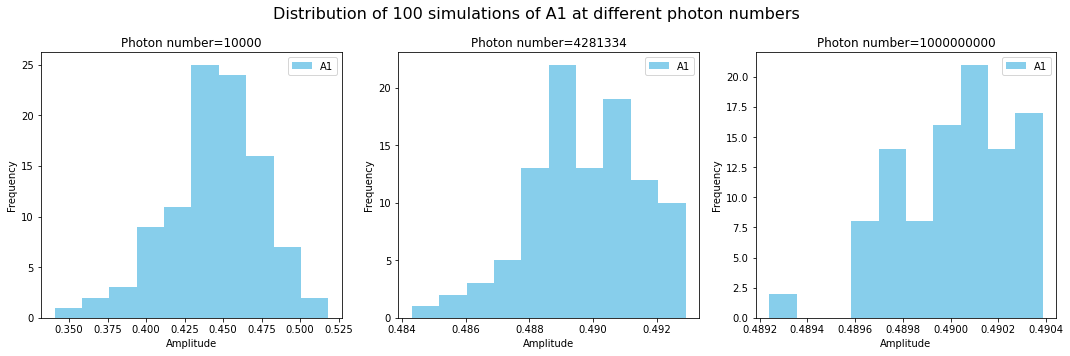

In [48]:
# Setup for loop parameters
indices = [0, 10, 19]  # Indices for low, middle, high photon number
titles = ['Photon number=10000', 'Photon number=4281334', 'Photon number=1000000000']
colors = ['skyblue', 'skyblue', 'skyblue']  # Using the same color, but allows customization
bins = 10  # Assuming you want the same number of bins for each histogram

# Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

for i, (index, title) in enumerate(zip(indices, titles)):
    axs[i].hist(n_val_df.loc[index, 'A1'], bins=bins, color=colors[i])
    axs[i].set_xlabel('Amplitude')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(title)
    axs[i].legend(['A1'])

# Add a main title for the plots
fig.suptitle('Distribution of 100 simulations of A1 at different photon numbers', fontsize=16)

# Adjust layout to prevent overlapping
plt.subplots_adjust(top=0.85)

plt.tight_layout()
plt.show()


In [63]:
mean_df = n_val_df.groupby(level=0).mean()
std_df = n_val_df.groupby(level=0).std()

<ipython-input-94-03ace1a9df5a>:17: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


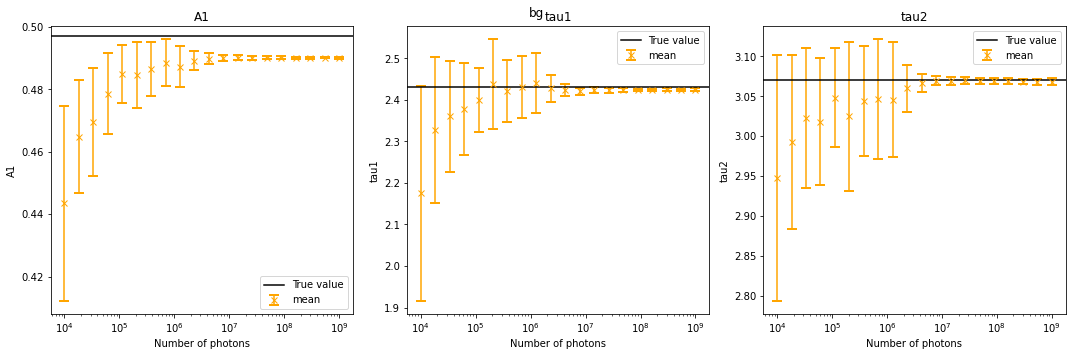

In [94]:
# Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
true = [0.497,2.43,3.07]
# A1 plot
for i in range(3):
    col = ['A1','tau1','tau2'][i] #column name
    axs[i].errorbar(n_photon_arr, mean_df[col], yerr=std_df[col], fmt='x', ecolor='orange', capthick=2,
                    capsize=5, color='orange', label='mean')
    axs[i].axhline(y=true[i], color='k', linestyle='-', label='True value')
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Number of photons')
    axs[i].set_ylabel(col)
    axs[i].set_title(col)
    axs[i].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
fig.suptitle('bg')
# Show the plot
plt.show()


In [67]:
par_dict = {k:v.value for k,v in mi1.params.items()}
A_sum = sum([par_dict[f'A{j}'] for j in range(1,N+1)])
for i in range(1,N+1):
  par_dict[f'A{i}']=par_dict[f'A{i}']/A_sum

In [68]:
par_dict

{'c': 0,
 'A1': 0.48894765828171666,
 'tau1': 2.412808994228439,
 'A2': 0.5110523417182833,
 'tau2': 3.086169138557101}

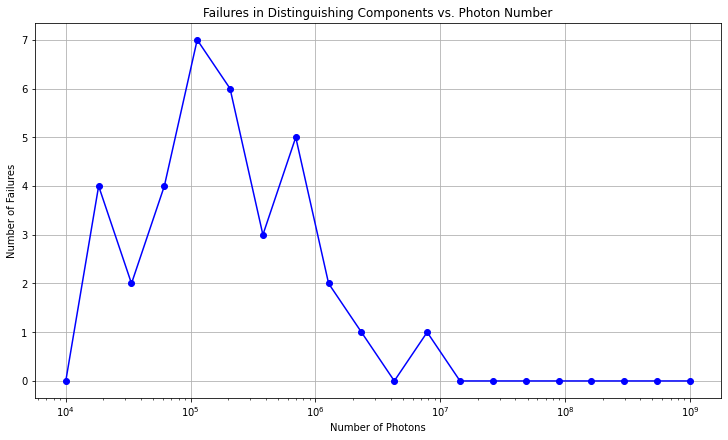

In [69]:
# Reset failure_counts to ensure clean start
failure_counts = []

# Assuming n_photon_arr is defined and correctly populated
for n_photon in n_photon_arr:
    failures = 0
    for j in range(100):  # For each simulation
        EGFP.n_photon = n_photon
        EGFP.repeat_sim(100)
        # Assuming the simulation data EGFP.sim_data[j] is correctly populated
        # and MLEfit function works as expected
        fit_results_df = MLEfit(2, EGFP.t, EGFP.sim_data[j], method='powell', end=100, rescale=False)
        
        # Extract fitted values
        A1 = fit_results_df['A1'].iloc[0]
        A2 = fit_results_df['A2'].iloc[0]
        tau1 = fit_results_df['tau1'].iloc[0]
        tau2 = fit_results_df['tau2'].iloc[0]

        # Failure condition
        if np.isclose(tau1, tau2, atol=0.2) or A1 > 0.8 or A2 > 0.8:
            failures += 1
    
    failure_counts.append(failures)

# Plotting the number of failures vs. n_photon
plt.figure(figsize=(10, 6))
plt.plot(n_photon_arr, failure_counts, marker='o', linestyle='-', color='blue')
plt.xscale('log')
plt.xlabel('Number of Photons')
plt.ylabel('Number of Failures')
plt.title('Failures in Distinguishing Components vs. Photon Number')
plt.grid(True)
plt.show()


# Remove Background


In [70]:
# Adjusted initial_params_no_bg function (already correct, just including for completeness)
def initial_params_no_bg(N, A_guess, tau_guess, rescale=False):
    p = lmfit.Parameters()
    p.add('c', value=0, vary=False)  # Background parameter fixed to 0 and not varied
    for i in range(1, N + 1):
        p.add(f'A{i}', value=A_guess[i - 1], min=0, vary=True)
        p.add(f'tau{i}', value=tau_guess[i - 1], min=0, vary=True)
    if rescale:
        expr = "1 - " + " - ".join([f"A{i}" for i in range(1, N)])
        p[f'A{N}'].set(expr=expr)
    return p

# Corrected MLEfit_no_bg function to use initial_params_no_bg
def MLEfit_no_bg(N, tdata, ydata, method='powell', end=100, rescale=False):
    tdata, ydata, weights = trim_rescale_data(tdata, ydata, end=end, rescale=rescale)
    A_guess = [np.max(ydata) * 0.49, np.max(ydata) * 0.51]
    p1 = initial_params_no_bg(N, A_guess, EGFP.tau, rescale=rescale)
    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k: [v.value] for k, v in mi1.params.items()}
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1, N + 1)])
    for i in range(1, N + 1):
        par_dict[f'A{i}'][0] = par_dict[f'A{i}'][0] / A_sum
    return pd.DataFrame.from_dict(par_dict), mi1  # Return both DataFrame and minimizer result for access to parameters

# Example call to MLEfit_no_bg (Ensure that EGFP.sim_data and other attributes are correctly initialized)
result_df, mi1 = MLEfit_no_bg(2, EGFP.t, EGFP.sim_data[2], method='powell', end=100, rescale=False)


In [71]:
# Correcting val_df1 to use the result from MLEfit_no_bg correctly
def val_df1():
    df1_list = []
    for j in range(100):
        df1, _ = MLEfit_no_bg(N, EGFP.t, EGFP.sim_data[j])  # Adjusted to capture the DataFrame correctly
        df1_list.append(df1)
    df1 = pd.concat(df1_list).reset_index()
    return df1.drop(['index'], axis=1)

# Assuming N, EGFP.t, and EGFP.sim_data are defined as per your setup
N = 2  # Number of components
df1_list = []
for i in range(len(n_photon_arr)):
    EGFP.n_photon = n_photon_arr[i]
    EGFP.repeat_sim(100)
    df1 = val_df1()  # Fit and compile results with background already removed
    df1_list.append(df1)

# Combine and analyze the results
n_val_df1 = pd.concat(df1_list, keys=range(20))
mean_df1 = n_val_df1.groupby(level=0).mean()
std_df1 = n_val_df1.groupby(level=0).std()

par_dict1 = {k:v.value for k,v in mi1.params.items()}
A_sum1 = sum([par_dict1[f'A{j}'] for j in range(1,N+1)])
for i in range(1,N+1):
  par_dict1[f'A{i}']=par_dict[f'A{i}']/A_sum

par_dict1

{'c': 0,
 'A1': 2.5702434594189682e-08,
 'tau1': 2.404562263045891,
 'A2': 2.6864408009197377e-08,
 'tau2': 3.0924035708950015}

<ipython-input-93-6b93d2b8bd8f>:17: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


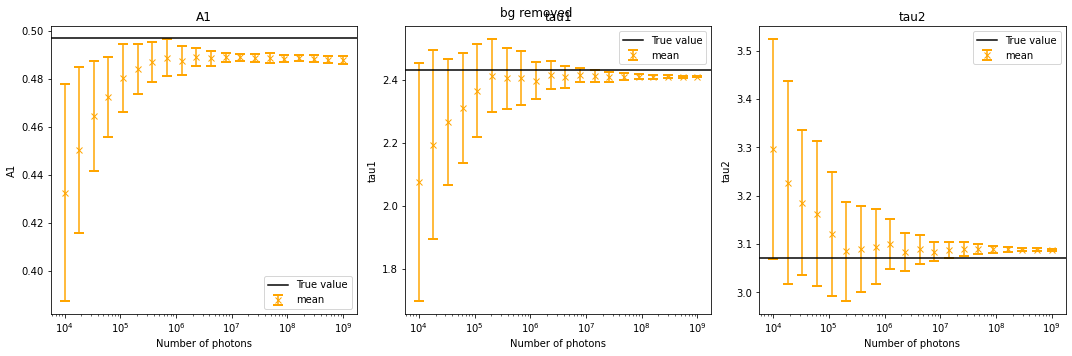

In [93]:
# Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
true = [0.497,2.43,3.07]
# A1 plot
for i in range(3):
    col = ['A1','tau1','tau2'][i] #column name
    axs[i].errorbar(n_photon_arr, mean_df1[col], yerr=std_df1[col], fmt='x', ecolor='orange', capthick=2,
                    capsize=5, color='orange', label='mean')
    axs[i].axhline(y=true[i], color='k', linestyle='-', label='True value')
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Number of photons')
    axs[i].set_ylabel(col)
    axs[i].set_title(col)
    axs[i].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
fig.suptitle('bg removed')
# Show the plot
plt.show()


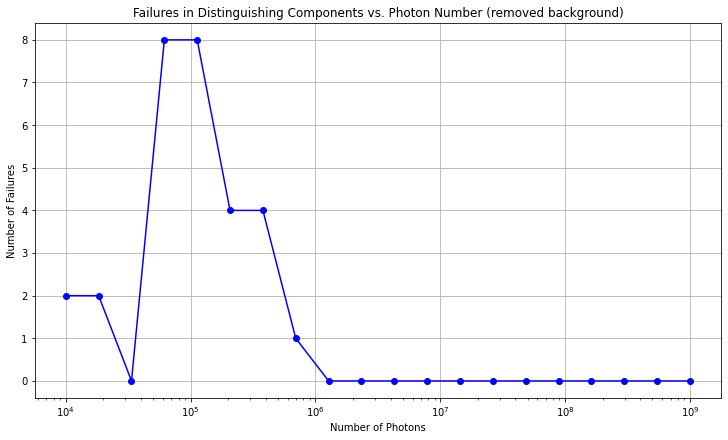

In [72]:
# Assuming the rest of your code setup is unchanged
failure_counts = []

for n_photon in n_photon_arr:
    failures = 0
    for j in range(100):  # For each simulation
        EGFP.n_photon = n_photon
        EGFP.repeat_sim(100)
        
        # Unpack the returned tuple correctly to get the DataFrame
        fit_results_df1, _ = MLEfit_no_bg(2, EGFP.t, EGFP.sim_data[j], method='powell', end=100, rescale=False)
        
        # Now you can safely extract fitted values
        A1 = fit_results_df1['A1'].iloc[0]
        A2 = fit_results_df1['A2'].iloc[0]
        tau1 = fit_results_df1['tau1'].iloc[0]
        tau2 = fit_results_df1['tau2'].iloc[0]

        # Check failure condition
        if np.isclose(tau1, tau2, atol=0.2) or A1 > 0.8 or A2 > 0.8:
            failures += 1
    
    failure_counts.append(failures)

# Plotting the number of failures vs. n_photon
plt.figure(figsize=(10, 6))
plt.plot(n_photon_arr, failure_counts, marker='o', linestyle='-', color='blue')
plt.xscale('log')
plt.xlabel('Number of Photons')
plt.ylabel('Number of Failures')
plt.title('Failures in Distinguishing Components vs. Photon Number (removed background)')
plt.grid(True)
plt.show()


# Plot with failures removed


<ipython-input-102-5395eabdf294>:44: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


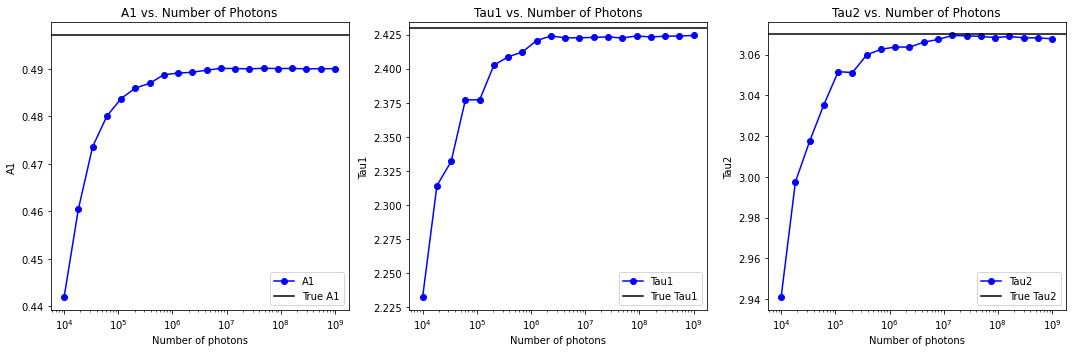

In [102]:
# Correcting the loop to properly handle the return value from MLEfit
for n_photon in n_photon_arr:
    temp_A1, temp_tau1, temp_tau2 = [], [], []
    
    EGFP.n_photon = n_photon
    EGFP.repeat_sim(100)  # Simulate data for the current photon level
    
    for j in range(100):  # For each simulation at this photon level
        # Directly capture the DataFrame returned by MLEfit
        fit_results_df = MLEfit(2, EGFP.t, EGFP.sim_data[j], method='powell', end=100, rescale=False)
  
        # Extract fitted values
        A1 = fit_results_df['A1'].iloc[0]
        A2 = fit_results_df['A2'].iloc[0]
        tau1 = fit_results_df['tau1'].iloc[0]
        tau2 = fit_results_df['tau2'].iloc[0]

        # Condition for successful fit
        if not (np.isclose(tau1, tau2, atol=0.2) or A1 > 0.8 or A2 > 0.8):
            temp_A1.append(A1)
            temp_tau1.append(tau1)
            temp_tau2.append(tau2)
    
    # If there were any successful fits for this photon level, calculate their averages
    if temp_A1:
        success_A1.append(np.mean(temp_A1))
        success_tau1.append(np.mean(temp_tau1))
        success_tau2.append(np.mean(temp_tau2))
        photon_success.append(n_photon)

# Plotting adjustment for correct variable names
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
parameters = [("A1", success_A1), ("Tau1", success_tau1), ("Tau2", success_tau2)]

for i, (param_name, values) in enumerate(parameters):
    axs[i].plot(photon_success, values, 'o-', color='blue', label=param_name)
    axs[i].axhline(y=true_values[i], color='k', linestyle='-', label=f"True {param_name}")
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Number of photons')
    axs[i].set_ylabel(param_name)
    axs[i].set_title(f"{param_name} vs. Number of Photons")
    axs[i].legend()

plt.tight_layout()
plt.show()


<ipython-input-108-a72f7e7d8560>:51: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


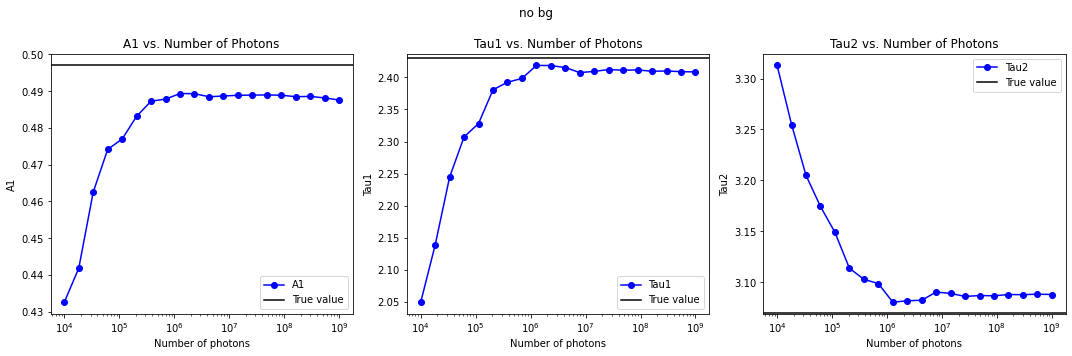

In [108]:
# Initialize lists to hold the successful parameter values and photon levels for plotting
successful_A1 = []
successful_tau1 = []
successful_tau2 = []
photon_levels_for_success = []

for n_photon in n_photon_arr:
    # Temporary lists to store successful parameter values for the current photon level
    temp_A1 = []
    temp_tau1 = []
    temp_tau2 = []

    EGFP.n_photon = n_photon
    EGFP.repeat_sim(100)

    for j in range(100):
        fit_results_df1, _ = MLEfit_no_bg(2, EGFP.t, EGFP.sim_data[j], method='powell', end=100, rescale=False)

        # Extract fitted values
        A1 = fit_results_df1['A1'].iloc[0]
        A2 = fit_results_df1['A2'].iloc[0]
        tau1 = fit_results_df1['tau1'].iloc[0]
        tau2 = fit_results_df1['tau2'].iloc[0]

        # Determine if the fit is considered successful
        if not (np.isclose(tau1, tau2, atol=0.2) or A1 > 0.8 or A2 > 0.8):
            temp_A1.append(A1)
            temp_tau1.append(tau1)
            temp_tau2.append(tau2)

    # If there were any successful fits, average their parameter values and record them
    if temp_A1:
        successful_A1.append(np.mean(temp_A1))
        successful_tau1.append(np.mean(temp_tau1))
        successful_tau2.append(np.mean(temp_tau2))
        photon_levels_for_success.append(n_photon)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
parameters = [("A1", successful_A1), ("Tau1", successful_tau1), ("Tau2", successful_tau2)]
true_values = [0.497, 2.43, 3.07]

for i, (label, data) in enumerate(parameters):
    axs[i].plot(photon_levels_for_success, data, 'o-', label=label, color='blue')
    axs[i].axhline(y=true_values[i], color='k', linestyle='-', label='True value')
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Number of photons')
    axs[i].set_ylabel(label)
    axs[i].set_title(f"{label} vs. Number of Photons")
    axs[i].legend()

plt.tight_layout()
fig.suptitle('no bg')
plt.subplots_adjust(top=0.85)
plt.show()

In [74]:
EGFP = Phasor([0.497,0.503],[2.43,3.07])  

In [75]:
 sim = EGFP
sim.phasor_true = multi_exp_FT(sim.w,sim.amp,sim.tau) #analytic phasor
n_photon_arr = np.logspace(4,9,20).astype(int)
def repeat_sim_n(sim,n_photon_arr = np.logspace(4,9,20).astype(int),n_repeat = 100):
    '''Store results of simulations for Simulation object sim 
    of n_photon in n_photon_arr (default  np.logspace(6,10,100).astype(int))
    Input:
    sim            Simulation Object
    n_photon_arr   Number of photons (collected in total) array
    n_repeat       Number of repeats in simulation
    '''
    sim.y_list = np.zeros((len(n_photon_arr),n_repeat,380)) #array to store 100 simulations of time domain data for each n_photon
    sim.phasor_list = np.zeros((len(n_photon_arr),n_repeat,380),dtype = complex) #array to store phasors from simulations of different n_photon
    sim.phasor_bg_list = np.zeros((len(n_photon_arr),n_repeat,380),dtype = complex) #with background
    for i in range(len(n_photon_arr)):
        sim.n_photon = n_photon_arr[i] #set n_photon
        sim.repeat_sim(n_repeat) #generate 100 simulations
        sim.y_list[i] = sim.sim_data #store 100 decays
        sim.phasor_list[i] = sim.phasor_data #store 100 phasors
        w,sim.phasor_bg_list[i] = sim.phasor_fft(sim.sim_data) #phasor with backhround
    
repeat_sim_n(sim)